In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [84]:
toxprot_17 = pd.read_csv('../data/processed/toxprot_2017.csv')
toxprot_25 = pd.read_csv('../data/processed/toxprot_2025.csv')

In [85]:
filtered = toxprot_17['Protein families'][toxprot_17['Protein families'].str.contains(';', na=False)]
filtered.value_counts()

Protein families
In the C-terminal section; belongs to the natriuretic peptide family.                                                                                   14
Melittin family. - Issue 12 of July 2001; URL="https://web.expasy.org/spotlight/back_issues/012";                                                        4
In the C-terminal section; belongs to the venom metalloproteinase (M12B) family.                                                                         3
Sea anemone sodium channel inhibitory toxin family. Type I subfamily. URL="https://en.wikipedia.org/wiki/Anthopleurin";                                  2
Long (4 C-C) scorpion toxin superfamily. Sodium channel inhibitor family. Beta subfamily. Sequence=CAA63431.1; Type=Erroneous initiation; Evidence=;     1
                                                                                                                                                        ..
Huwentoxin-1 family. Jztx-9 subfamily. Sequence=ABY71

In [86]:
def change_protfams(df):
    df['Protein families'] = df['Protein families'].str.split('.').str[0]
    df['Protein families'] = df['Protein families'].str.split(',').str[0]
    df['Protein families'] = df['Protein families'].str.split(';').str[0]

    df['Protein families'] = df['Protein families'].replace('I1 superfamily', 'Conotoxin I1 superfamily')
    df['Protein families'] = df['Protein families'].replace('O1 superfamily', 'Conotoxin O1 superfamily')
    df['Protein families'] = df['Protein families'].replace('O2 superfamily', 'Conotoxin O2 superfamily')
    df['Protein families'] = df['Protein families'].replace('E superfamily', 'Conotoxin E superfamily')
    df['Protein families'] = df['Protein families'].replace('F superfamily', 'Conotoxin F superfamily')
    df['Protein families'] = df['Protein families'].replace('Conotoxin M family', 'Conotoxin M superfamily')
    df['Protein families'] = df['Protein families'].replace('Conotoxin B2 family', 'Conotoxin B2 superfamily')
    df['Protein families'] = df['Protein families'].replace('Conotoxin O1 family', 'Conotoxin O1 superfamily')
    df['Protein families'] = df['Protein families'].replace('Conotoxin O2 family', 'Conotoxin O2 superfamily')

    return df
change_protfams(toxprot_17)
change_protfams(toxprot_25)

,Entry,Organism (ID),Protein families,Length,Fragment,Toxic dose,PTM,Scientific_Name,Order,Family,Genus,Habitat
0,A0A068B6Q6,89764,Conotoxin A superfamily,37,fragment,NaN,NaN,Conus betulinus,Neogastropoda,Conidae,Conus,marine
1,A0A088MIT0,248869,Frog skin active peptide (FSAP) family,134,NaN,NaN,NaN,Physalaemus nattereri,Anura,Leptodactylidae,Physalaemus,terrestrial
2,A0A0A1I6E7,122909,Non-disulfide-bridged peptide (NDBP) superfamily,74,NaN,NaN,NaN,Androctonus crassicauda,Scorpiones,Buthidae,Androctonus,terrestrial
3,A0A0A1I6N9,122909,Non-disulfide-bridged peptide (NDBP) superfamily,74,NaN,NaN,NaN,Androctonus crassicauda,Scorpiones,Buthidae,Androctonus,terrestrial
4,A0A0B4U9L8,8705,Venom metalloproteinase (M12B) family,614,NaN,NaN,PTM: N-glycosylated. {ECO:0000269|PubMed:25549...,Vipera ammodytes ammodytes,Squamata,Viperidae,Vipera,terrestrial
...,...,...,...,...,...,...,...,...,...,...,...,...
8050,P86344,662117,NaN,10,fragment,NaN,NaN,Brotheas amazonicus,Scorpiones,Chactidae,Brotheas,terrestrial
8051,P86827,6887,Non-disulfide-bridged peptide (NDBP) superfamily,7,NaN,NaN,NaN,Tityus serrulatus,Scorpiones,Buthidae,Tityus,terrestrial
8052,Q45RU8,6493,NaN,44,fragment,NaN,PTM: Contains 3 disulfide bonds. {ECO:0000305}.,Conus striatus,Neogastropoda,Conidae,Conus,marine
8053,Q7M463,34649,NaN,29,NaN,NaN,PTM: Contains 3 disulfide bonds. {ECO:0000305}.,Olivierus martensii,Scorpiones,Buthidae,Olivierus,terrestrial


In [87]:
toxprot_17

,Entry,Organism (ID),Protein families,Length,Fragment,Toxic dose,PTM,Scientific_Name,Order,Family,Genus,Habitat
0,P84001,280265,NaN,50,fragment,NaN,NaN,Ancylometes sp. MR-2004,Araneae,Ctenidae,Ancylometes,terrestrial
1,P84027,280265,Omega-agatoxin superfamily,37,fragment,NaN,NaN,Ancylometes sp. MR-2004,Araneae,Ctenidae,Ancylometes,terrestrial
2,Q7M3V1,132888,NaN,246,NaN,NaN,NaN,Chelonus sp. near curvimaculatus,Hymenoptera,Braconidae,Chelonus,terrestrial
3,F8J2B3,66186,Snake three-finger toxin family,108,NaN,NaN,NaN,Drysdalia coronoides,Squamata,Elapidae,Drysdalia,terrestrial
4,Q53B54,8665,Snake three-finger toxin family,72,NaN,LD(50) is 210 ug/kg by intraperitoneal injecti...,NaN,Ophiophagus hannah,Squamata,Elapidae,Ophiophagus,terrestrial
...,...,...,...,...,...,...,...,...,...,...,...,...
6698,P0C2K8,58216,Arthropod phospholipase D family,7,fragment,NaN,NaN,Loxosceles gaucho,Araneae,Sicariidae,Loxosceles,terrestrial
6699,C0HKQ5,135722,NaN,17,NaN,NaN,NaN,Xylocopa appendiculata circumvolans,Hymenoptera,Apidae,Xylocopa,terrestrial
6700,C0HKQ6,135722,NaN,17,NaN,NaN,NaN,Xylocopa appendiculata circumvolans,Hymenoptera,Apidae,Xylocopa,terrestrial
6701,Q7LZ26,36307,NaN,12,fragment,NaN,NaN,Deinagkistrodon acutus,Squamata,Viperidae,Deinagkistrodon,terrestrial


In [88]:
toxprot_17["Fragment"].value_counts(dropna=False)

Fragment
NaN         5539
fragment    1164
Name: count, dtype: int64

In [89]:
toxprot_25['Protein families'].value_counts()

Protein families
Phospholipase A2 family                    543
Snake three-finger toxin family            536
Long (4 C-C) scorpion toxin superfamily    426
Neurotoxin 10 (Hwtx-1) family              290
Venom metalloproteinase (M12B) family      286
                                          ... 
Scolopendra toxin 9 family                   1
ATP:guanido phosphotransferase family        1
Diapausin family                             1
DNase II family                              1
SLPTX(15) family                             1
Name: count, Length: 304, dtype: int64

### Figures

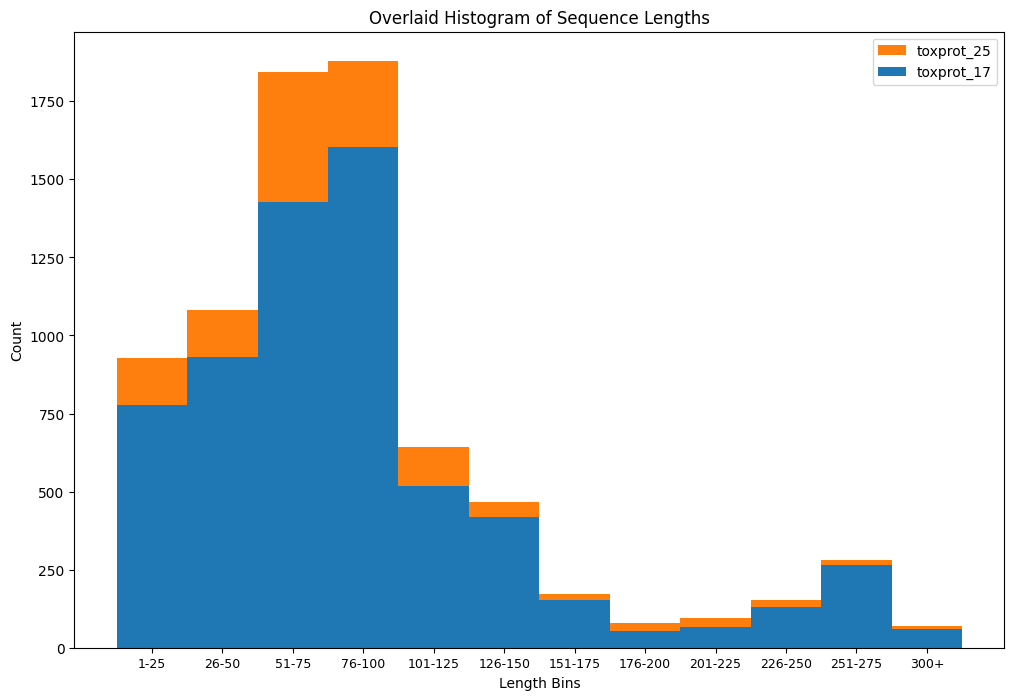

In [90]:
bins = np.arange(1, 325, 25)

bin_labels = [f"{start}-{end - 1}" for start, end in zip(bins[:-1], bins[1:])]
bin_labels[-1] = "300+"

lengths_25 = toxprot_25["Length"]
lengths_17 = toxprot_17["Length"]

plt.figure(figsize=(12, 8))
plt.hist(lengths_25, bins=bins, color=plt.cm.tab10(1), label="toxprot_25")
plt.hist(lengths_17, bins=bins, color=plt.cm.tab10(0), label="toxprot_17")

plt.xlabel("Length Bins")
plt.ylabel("Count")
plt.title("Overlaid Histogram of Sequence Lengths")

plt.xticks(bins[:-1] + 12.5, bin_labels, fontsize=9)

plt.legend()
plt.savefig("../figures/overlaid_hist.png", dpi=300)

plt.show()
plt.close()

In [91]:
toxprot_17['Fragment'].value_counts()

Fragment
fragment    1164
Name: count, dtype: int64

In [92]:
na_count_17 = toxprot_17['Protein families'].isna().sum()  # Count NaN values
total_count_17 = len(toxprot_17['Protein families'])  # Total number of entries
na_percentage_17 = (na_count_17 / total_count_17) * 100 if total_count_17 > 0 else 0  # Calculate percentage
unique_families_17 = len(toxprot_17['Protein families'].dropna().unique())

print(f'N/A (NaN) Count: {na_count_17}')
print(f'{unique_families_17}')
print(f'N/A (NaN) Percentage: {na_percentage_17:.2f}%')

na_count_25 = toxprot_25['Protein families'].isna().sum()  # Count NaN values
total_count_25 = len(toxprot_25['Protein families'])  # Total number of entries
na_percentage_25 = (na_count_25 / total_count_25) * 100 if total_count_25 > 0 else 0  # Calculate percentage
unique_families_25 = len(toxprot_25['Protein families'].dropna().unique())

print(f'N/A (NaN) Count: {na_count_25}')
print(f'{unique_families_25}')
print(f'N/A (NaN) Percentage: {na_percentage_25:.2f}%')


N/A (NaN) Count: 584
195
N/A (NaN) Percentage: 8.71%
N/A (NaN) Count: 591
304
N/A (NaN) Percentage: 7.34%


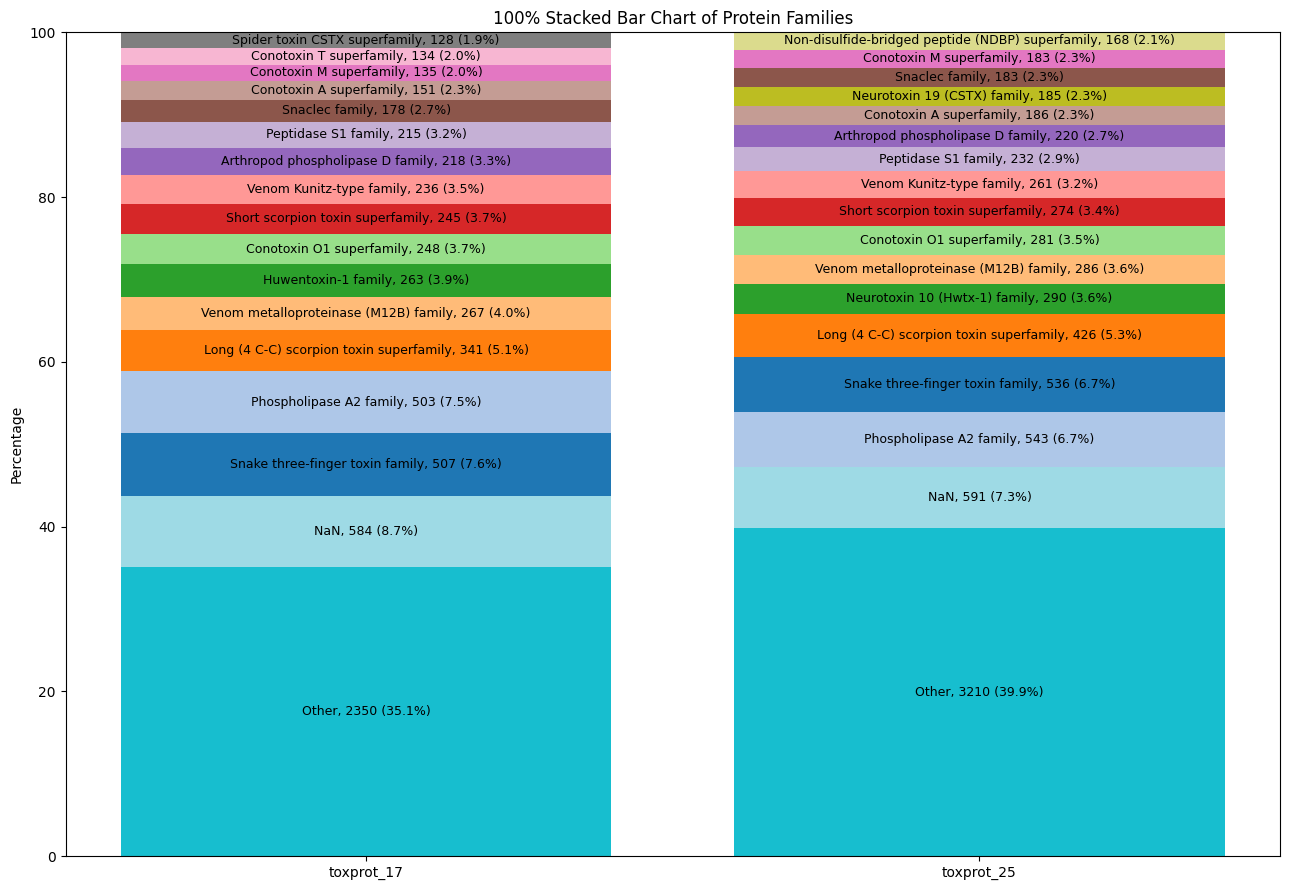

In [101]:
def get_top_families_per_dataset(df, column, top_n=15):
    counts = df[column].value_counts()
    top_counts = counts.nlargest(top_n)
    other_count = counts.iloc[top_n:].sum()
    nan_count = df[column].isna().sum()

    top_counts["Other"] = other_count
    if nan_count > 0:
        top_counts["NaN"] = nan_count
    return top_counts

# Get top families per dataset
top_17 = get_top_families_per_dataset(toxprot_17, "Protein families", top_n=15)
top_25 = get_top_families_per_dataset(toxprot_25, "Protein families", top_n=15)

# Build unified index
top_17_sorted = top_17.sort_values(ascending=False)
top_25_sorted = top_25.sort_values(ascending=False)
all_families = top_17_sorted.index.to_list()
for fam in top_25_sorted.index:
    if fam not in all_families:
        all_families.append(fam)

# Create DataFrames
df_stacked = pd.DataFrame(index=all_families)
df_stacked["toxprot_17"] = top_17.reindex(all_families).fillna(0)
df_stacked["toxprot_25"] = top_25.reindex(all_families).fillna(0)
df_stacked_perc = df_stacked.div(df_stacked.sum()) * 100

# Colors
colors = plt.colormaps["tab20"]
families_no_nan_other = [f for f in all_families if f not in ("Other", "NaN")]
color_map = {fam: colors(i) for i, fam in enumerate(families_no_nan_other)}
color_map["Other"] = colors(18)
color_map["NaN"]   = colors(19)
if "Huwentoxin-1 family" in color_map:
    color_map["Neurotoxin 10 (Hwtx-1) family"] = color_map["Huwentoxin-1 family"]

# Plot
fig, ax = plt.subplots(figsize=(13, 9))

# Bar 1 (toxprot_17)
bottom = 0
order_17 = df_stacked["toxprot_17"].sort_values(ascending=False).index
bars17 = []
for fam in order_17:
    pct = df_stacked_perc.at[fam, "toxprot_17"]
    cnt = df_stacked.at[fam, "toxprot_17"]
    if cnt > 0:
        bar = ax.bar("toxprot_17", pct, bottom=bottom,
                     color=color_map.get(fam, "gray"))[0]
        bars17.append((bar, fam, cnt, pct))
    bottom += pct

# Bar 2 (toxprot_25)
bottom = 0
order_25 = df_stacked["toxprot_25"].sort_values(ascending=False).index
bars25 = []
for fam in order_25:
    pct = df_stacked_perc.at[fam, "toxprot_25"]
    cnt = df_stacked.at[fam, "toxprot_25"]
    if cnt > 0:
        bar = ax.bar("toxprot_25", pct, bottom=bottom,
                     color=color_map.get(fam, "gray"))[0]
        bars25.append((bar, fam, cnt, pct))
    bottom += pct

# Add labels using each bar’s .get_x()/.get_width()
for bar, fam, cnt, pct in bars17 + bars25:
    ax.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_y() + bar.get_height()/2,
        f"{fam}, {int(cnt)} ({pct:.1f}%)",
        ha="center", va="center", fontsize=9, wrap=True
    )

# Final formatting
ax.set_ylabel("Percentage")
ax.set_title(
    "100% Stacked Bar Chart of Protein Families"
)
ax.set_ylim(0, 100)
ax.tick_params(axis="x", labelsize=10)
ax.tick_params(axis="y", labelsize=10)

plt.tight_layout()
plt.savefig("../figures/stacked_bar_protfam.png", dpi=300)
plt.show()
plt.close()

In [94]:
# Ensure the 'Fragment' column is treated as a string
toxprot_17['Fragment'] = toxprot_17['Fragment'].astype(str)
toxprot_25['Fragment'] = toxprot_25['Fragment'].astype(str)

# Count occurrences of "fragment" (case-insensitive)
fragment_count_17 = toxprot_17['Fragment'].str.contains("fragment", case=False, na=False).sum()
total_count_17 = toxprot_17.shape[0]
fragment_percentage_17 = (fragment_count_17 / total_count_17) * 100 if total_count_17 > 0 else 0

print(f'Fragment Count 17: {fragment_count_17}')
print(f'Fragment Percentage 17: {fragment_percentage_17:.2f}%')

fragment_count_25 = toxprot_25['Fragment'].str.contains("fragment", case=False, na=False).sum()
total_count_25 = toxprot_25.shape[0]
fragment_percentage_25 = (fragment_count_25 / total_count_25) * 100 if total_count_25 > 0 else 0

print(f'Fragment Count 25: {fragment_count_25}')
print(f'Fragment Percentage 25: {fragment_percentage_25:.2f}%')

Fragment Count 17: 1164
Fragment Percentage 17: 17.37%
Fragment Count 25: 1300
Fragment Percentage 25: 16.14%


In [12]:
# Count occurrences where PTM is not NaN
ptm_count_17 = toxprot_17['PTM'].notna().sum()
ptm_percentage_17 = (ptm_count_17 / total_count_17) * 100 if total_count_17 > 0 else 0

print(f'ptm Count (2017): {ptm_count_17}')
print(f'ptm Percentage (2017): {ptm_percentage_17:.2f}%')

# Count occurrences where PTM is not NaN in 2025 datap
ptm_count_25 = toxprot_25['PTM'].notna().sum()
ptm_percentage_25 = (ptm_count_25 / total_count_25) * 100 if total_count_25 > 0 else 0

print(f'ptm Count (2025): {ptm_count_25}')
print(f'ptm Percentage (2025): {ptm_percentage_25:.2f}%')

ptm Count (2017): 964
ptm Percentage (2017): 14.38%
ptm Count (2025): 1380
ptm Percentage (2025): 17.13%


In [13]:
# Count occurrences where toxic is not NaN
toxic_count_17 = toxprot_17['Toxic dose'].notna().sum()
toxic_percentage_17 = (toxic_count_17 / total_count_17) * 100 if total_count_17 > 0 else 0

print(f'toxic Count (2017): {toxic_count_17}')
print(f'toxic Percentage (2017): {toxic_percentage_17:.2f}%')

# Count occurrences where toxic is not NaN in 2025 data
toxic_count_25 = toxprot_25['Toxic dose'].notna().sum()
toxic_percentage_25 = (toxic_count_25 / total_count_25) * 100 if total_count_25 > 0 else 0

print(f'Toxic dose Count (2025): {toxic_count_25}')
print(f'PTM Percentage (2025): {toxic_percentage_25:.2f}%')

toxic Count (2017): 584
toxic Percentage (2017): 8.71%
Toxic dose Count (2025): 680
PTM Percentage (2025): 8.44%


In [16]:
len(toxprot_17["Scientific_Name"].value_counts())

740

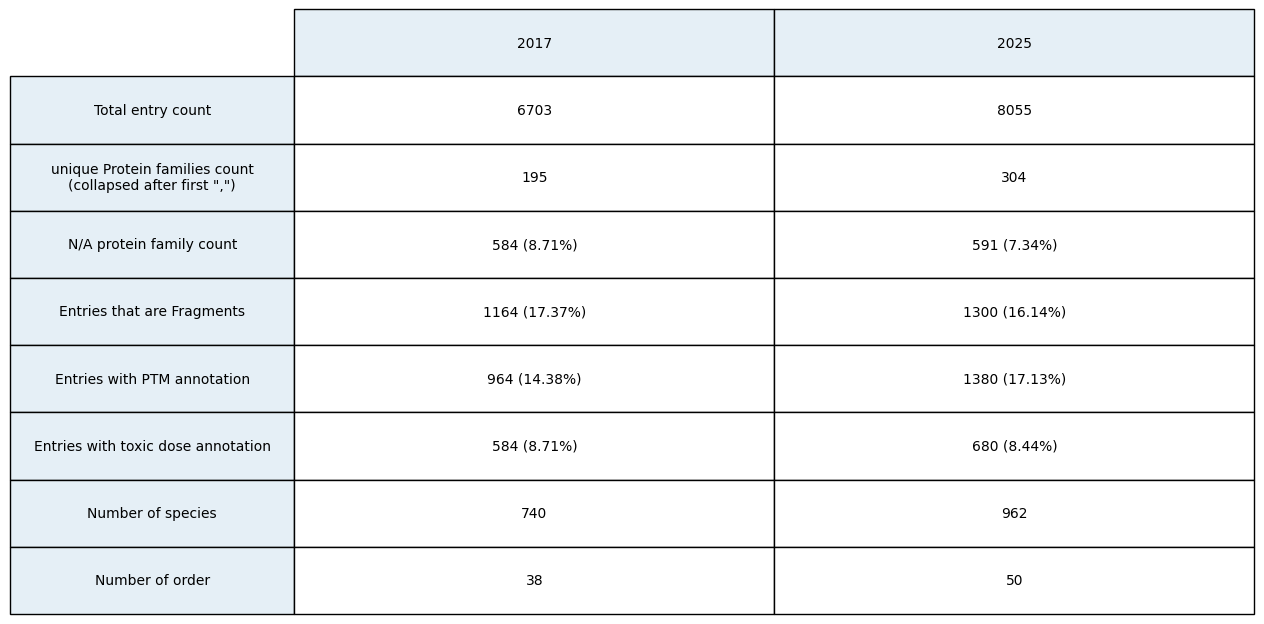

In [17]:
cell_text = [[total_count_17, total_count_25],
             [unique_families_17, unique_families_25],
             [f'{na_count_17} ({na_percentage_17:.2f}%)', f'{na_count_25} ({na_percentage_25:.2f}%)'],
             [f'{fragment_count_17} ({fragment_percentage_17:.2f}%)', f'{fragment_count_25} ({fragment_percentage_25:.2f}%)'],
             [f'{ptm_count_17} ({ptm_percentage_17:.2f}%)', f'{ptm_count_25} ({ptm_percentage_25:.2f}%)'],
             [f'{toxic_count_17} ({toxic_percentage_17:.2f}%)', f'{toxic_count_25} ({toxic_percentage_25:.2f}%)'],
             [len(toxprot_17["Scientific_Name"].unique()), len(toxprot_25["Scientific_Name"].unique())],
             [len(toxprot_17["Order"].unique()), len(toxprot_25["Order"].unique())],
             ]
row_headers = ['Total entry count',
               'unique Protein families count\n(collapsed after first ",")',
               'N/A protein family count',
               'Entries that are Fragments',
               'Entries with PTM annotation',
               'Entries with toxic dose annotation',
               'Number of species',
               'Number of order']
column_headers = ['2017', '2025']

rcolors = plt.cm.BuPu(np.full(len(row_headers), 0.1))
ccolors = plt.cm.BuPu(np.full(len(column_headers), 0.1))

fig, ax = plt.subplots(figsize=(12, 6))
ax.axis('tight')
ax.axis('off')

the_table = plt.table(cellText=cell_text,
                      rowLabels=row_headers,
                      rowColours=rcolors,
                      rowLoc='center',
                      colColours=ccolors,
                      colLabels=column_headers,
                      cellLoc='center',
                      loc='center')

table_props = the_table.properties()
cells = table_props['children']
for cell in cells:
    cell.set_height(0.14)

for cell in cells:
    cell.set_fontsize(10)

for i, key in enumerate(the_table._cells):
    if key[0] == 0:  # Column labels
        the_table._cells[key].set_fontsize(15)
    if key[1] == 0:  # Row labels
        the_table._cells[key].set_fontsize(15)

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

plt.savefig("../figures/table.png", dpi=300, bbox_inches='tight')
plt.show()